<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/fit_mulltiple_1d_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an example of how to fit multiple 1-d gaussians simultaneously in python as may be done in spec_fit. Code based on discussion at https://stackoverflow.com/questions/34136737/using-scipy-curve-fit-for-a-variable-number-of-parameters

Author: dmehring 12jan2022

Install casatools

In [446]:
import os
print("installing casatools (takes a minute)...")
os.system("apt-get install libgfortran3")
os.system("pip install casatools==6.3.0.48")
os.system('pip install casadata')
print('complete')

installing casatools (takes a minute)...
complete


imports

In [447]:
from casatools import functional
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

Define functions to determine rms and compute model values

In [448]:
def __rms(y: np.array) -> float:
  return np.sqrt(np.sum(y*y)/len(y))

def __model(x: np.array, g1d: list) -> np.array:
  m = np.zeros(len(x))
  for g in g1d:
    m += g.f(x)
  return m

Define chi square for curve fitting

In [449]:
def __chi_square(y: np.array, model: np.array, sigma: float) -> float:
  residual_sigma = (model - y)/sigma
  return np.sum(residual_sigma*residual_sigma)

Compute and return rms and chi-square

In [450]:
def __rms_chisquare(y: np.array, model: np.array, sigma: float) -> tuple:
  return __rms(y - model), __chi_square(y, model, sigma)

Define function to plot data

In [451]:
# plot the data
def __plot(
    x: np.array, y: np.array, residual: np.array, x_smooth: np.array,
    model_smooth: np.array, fit: bool=False
  ) -> None:
  plt.plot(x, y, linestyle='', marker='o', markerfacecolor='red')
  plt.plot(x, residual, linestyle='', marker='x', markerfacecolor='#50C878')
  plt.plot(x_smooth, model_smooth, color='blue')
  plt.xlabel('V_LSR (km/s)')
  plt.ylabel('Intensity (Jy/beam')
  if fit:
    plt.title('Model Spectrum with Fit')
  else:
    plt.title('Model Spectrum')
  plt.show()


Create model.

In [452]:
def __create_model(amplitude: list, center: list, fwhm: list) -> tuple:
  fn = functional()
  g1d: functional = []
  for a, c, f in zip(amplitude, center, fwhm):
    g1d.append(fn.gaussian1d(a, c, f))
  return g1d, len(g1d)

Define wrapper function that is used to fit multiple gaussians
N = number of gaussians to fit

In [453]:
def wrapper_fit_func(x, N, *args):
  amp, center, fwhm = args[:N], args[N:2*N], args[2*N:3*N]
  g1d = []
  for a, c, f in zip(amp, center, fwhm):
    g1d.append(fn.gaussian1d(a, c, f))
  return __model(x, g1d)

Create data

In [454]:
def __create_data(npixels: int, noise: float, model: list) -> tuple:
  residual = np.random.normal(0, noise, npixels)
  x = np.linspace(0, npixels, npixels, endpoint=False)
  m = __model(x, model)
  y = m + residual
  x_smooth = np.linspace(0, npixels, 100)
  model_smooth = __model(x_smooth, model)
  return x, y, m, residual, x_smooth, model_smooth

This function does the fit

In [455]:
def __fit(x: np.array, y: np.array, ngauss: int, params_0: list) -> list:
  try:
    popt, pcov = curve_fit(
        lambda x, *params_0:
          wrapper_fit_func(x, ngauss, *params_0), x, y, p0=params_0
      )
    perr: np.array = np.sqrt(np.diag(pcov))
    return popt, perr
  except RuntimeError as e:
    raise RuntimeError(f'Fit did not converge {e}')

Function to report the fit

In [456]:
def __report(
    popt: np.array, perr: np.array, y: np.array, noise: float, rms_orig: float,
    chi2_orig: float, ndigits: int
  ) -> np.array:
  popt = popt.round(ndigits)
  perr = perr.round(ndigits)
  amp_fit = popt[0:ngauss]
  center_fit = popt[ngauss:2*ngauss]
  fwhm_fit = popt[2*ngauss:3*ngauss]
  amp_err = perr[0:ngauss]
  center_err = perr[ngauss:2*ngauss]
  fwhm_err = perr[2*ngauss:3*ngauss]
  g1d_fit: list = []
  for i, (af, cf, ff, ae, ce, fe) in enumerate(
    zip(amp_fit, center_fit, fwhm_fit, amp_err, center_err, fwhm_err)
  ):
    print(f'Solution for gaussian {i}:')
    print(f'  Amplitude: {af} +/- {ae}')
    print(f'  Center: {cf} +/- {ce}')
    print(f'  FWHM: {ff} +/- {fe}')
    print()
    g1d_fit.append(fn.gaussian1d(af, cf, ff))
  model = __model(x, g1d_fit)
  rms_fit, chi2_fit = __rms_chisquare(y, model, noise)
  print(f'rms of residuals of fit: {round(rms_fit, 3)}')
  print(
    f'Fit residuals have an rms that is {round(100*rms_fit/rms_orig, 3)}% ',
    'of the rms of the original residuals'
  )
  print()
  print(f'chi-square of fit: {round(chi2_fit, 3)}')

  print(
    f'Chi-square of fit is {round(100*chi2_fit/chi2_orig, 3)}% '
    'chi-square of original'
  )
  return model

# TWO GAUSSIANS

In [457]:
# create a model with 2 gaussians
# first, create an array of 2 1-d gaussian functionals
g1d, ngauss = __create_model(amplitude=[5, 3], center=[10, 4], fwhm=[4, 6])
# now create some data with noise
x,  y, model, residual, x_smooth, model_smooth = __create_data(20, 0.2, g1d)

Compute and report the rms of the residuals

In [458]:
rms_orig, chi2_orig = __rms_chisquare(y, model, noise)
print(f'rms of residuals: {round(rms_orig, 3)}')
print(f'chi2: {round(chi2_orig, 3)}')

rms of residuals: 0.148
chi2: 10.953


Plot the data with the model overlaid

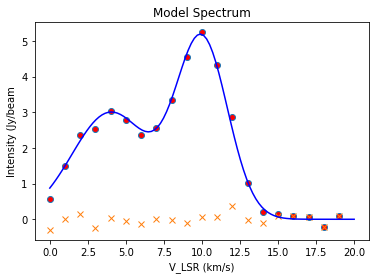

In [459]:
__plot(x, y, residual, x_smooth, model_smooth)

Perform the fit of two 1-d gaussians to the data

In [460]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 5, 5, 7]
popt, perr = __fit(x, y, ngauss, params_0)

Summarize the fit

In [461]:
model = __report(popt, perr, y, noise, rms_orig, chi2_orig, 3)

Solution for gaussian 0:
  Amplitude: 5.087 +/- 0.121
  Center: 10.032 +/- 0.071
  FWHM: 4.081 +/- 0.149

Solution for gaussian 1:
  Amplitude: 2.971 +/- 0.097
  Center: 3.972 +/- 0.145
  FWHM: 5.743 +/- 0.387

rms of residuals of fit: 0.13
Fit residuals have an rms that is 87.722%  of the rms of the original residuals

chi-square of fit: 8.429
Chi-square of fit is 76.951% chi-square of original


Plot the data with the best fit model overlaid

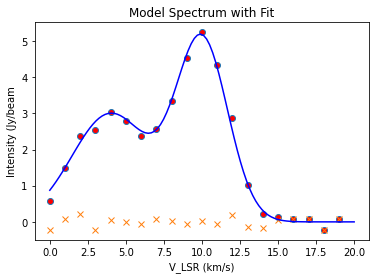

In [462]:
model_smooth = __model(x_smooth, g1d)
__plot(x, y, y-model, x_smooth, model_smooth, True)        

# FOUR GAUSSIANS

In [463]:
# create a model with 4 gaussians
# first, create an array of 4 1-d gaussian functionals
g1d, ngauss = __create_model(
    amplitude=[5, 3, 10, 7], center=[10, 4, 15, 20], fwhm=[4, 6, 6, 3]
  )
# then create data with noise
x, y, model, residual, x_smooth, model_smooth = __create_data(40, 0.2, g1d)

In [464]:
rms_orig, chi2_orig = __rms_chisquare(y, model, noise)
print(f'rms of residuals: {round(rms_orig, 3)}')
print(f'chi2: {round(chi2_orig, 3)}')

rms of residuals: 0.238
chi2: 56.519


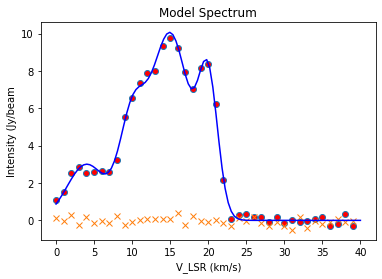

In [465]:
x_smooth = np.linspace(0, npixels, 100)
model_smooth = __model(x_smooth, g1d)
__plot(x, y, r, x_smooth, model_smooth)

In [466]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 8, 9, 5, 13, 22, 5, 7, 7, 4]
popt, perr = __fit(x, y, ngauss, params_0)

In [467]:
model = __report(popt, perr, y, noise, rms_orig, chi2_orig, 3)

Solution for gaussian 0:
  Amplitude: 5.256 +/- 1.271
  Center: 10.207 +/- 0.346
  FWHM: 4.24 +/- 0.663

Solution for gaussian 1:
  Amplitude: 2.805 +/- 0.146
  Center: 3.777 +/- 0.329
  FWHM: 6.532 +/- 0.922

Solution for gaussian 2:
  Amplitude: 9.663 +/- 0.219
  Center: 15.236 +/- 0.25
  FWHM: 6.111 +/- 1.047

Solution for gaussian 3:
  Amplitude: 6.858 +/- 0.776
  Center: 20.075 +/- 0.081
  FWHM: 2.854 +/- 0.218

rms of residuals of fit: 0.201
Fit residuals have an rms that is 84.524%  of the rms of the original residuals

chi-square of fit: 40.378
Chi-square of fit is 71.442% chi-square of original


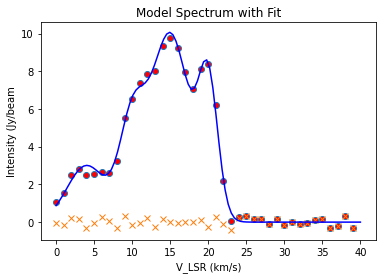

In [468]:
model_smooth = __model(x_smooth, g1d)
__plot(x, y, y-model, x_smooth, model_smooth, True)        